In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2       # type: ignore
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
train_path = '/home/theodoros/dataset/GTSRB/Final_Training/Images'
test_path = '/home/theodoros/dataset/GTSRB/Final_Test/Images'

In [3]:
def process_image(img_path, resizeSize):
    img = cv2.imread(img_path)
    img_resize = cv2.resize(img, resizeSize)
    img_norm = img_resize / 255.0
    gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)

    hog_desc, hog_image = hog(
        gray,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return img_norm, keypoints, descriptors, hog_desc, hog_image

def loadData(path, load_type, resizeSize=(32, 32)):
    images = []
    labels = []
    bboxes = []
    sift_features = []
    sift_keypoints = []
    hog_features = []
    hog_images = []

    if load_type == "Train":
        class_dirs = sorted(os.listdir(path))

        for class_id in class_dirs:
            class_dir = os.path.join(path, class_id)
            class_label = int(class_id)
            annotation_file = os.path.join(class_dir, f'GT-{class_id}.csv')
            annotations = pd.read_csv(annotation_file, sep=";")

            for _, row in annotations.iterrows():
                img_path = os.path.join(class_dir, row['Filename'])

                img_norm, keypoints, descriptors, hog_desc, hog_image = process_image(img_path, resizeSize)

                if descriptors is None:
                    continue

                bbox = {
                    'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                    'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                    'original_width': row['Width'], 'original_height': row['Height']
                }

                images.append(img_norm)
                labels.append(class_label)
                bboxes.append(bbox)
                sift_keypoints.append(keypoints)
                sift_features.append(descriptors)
                hog_features.append(hog_desc)
                hog_images.append(hog_image)
        
        print("Done, Train Images are loaded.")

    elif load_type == "Test":
        annotation_file = "/home/theodoros/dataset/GT-final_test.csv"
        annotations = pd.read_csv(annotation_file, sep=";")

        for _, row in annotations.iterrows():
            img_path = os.path.join(path, row['Filename'])
            class_label = int(row['ClassId'])

            img_norm, keypoints, descriptors, hog_desc, hog_image = process_image(img_path, resizeSize)

            if descriptors is None:
                continue

            bbox = {
                'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                'original_width': row['Width'], 'original_height': row['Height']
            }

            images.append(img_norm)
            labels.append(class_label)
            bboxes.append(bbox)
            sift_keypoints.append(keypoints)
            sift_features.append(descriptors)
            hog_features.append(hog_desc)
            hog_images.append(hog_image)
        
        print("Done, Test Images are loaded.")

    X = np.array(images)
    y = np.array(labels)

    return X, y, bboxes, sift_features, sift_keypoints, hog_features, hog_images

In [4]:
X_train, y_train, bboxes_train, sift_features_train, sift_keypoints_train, hog_features_train, hog_images_train = loadData(train_path, "Train")
X_test, y_test, bboxes_test, sift_features_test, sift_keypoints_test, hog_features_test, hog_images_test = loadData(test_path, "Test")

Done, Train Images are loaded.
Done, Test Images are loaded.


(35423, 32, 32, 3)
(35423,)


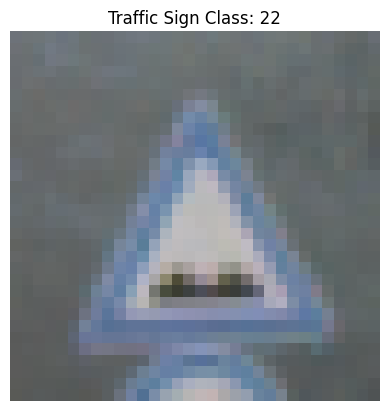

In [5]:
print(X_train.shape)  # N of images , hiehgt , width , channels 3 bcs we are on RGP
print(y_train.shape)

test_img = random.randint(0, X_train.shape[0])
plt.Figure(figsize=(5,5))

plt.imshow(X_train[test_img])
plt.title(f"Traffic Sign Class: {y_train[test_img]}")
plt.axis('off')
plt.show()

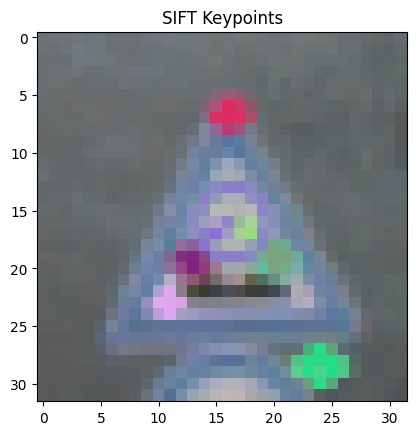

In [6]:
image_uint8 = (X_train[test_img] * 255).astype(np.uint8)
image_with_keypoints = cv2.drawKeypoints(image_uint8, sift_keypoints_train[test_img], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_with_keypoints, cmap="gray")
plt.title("SIFT Keypoints")
plt.show()

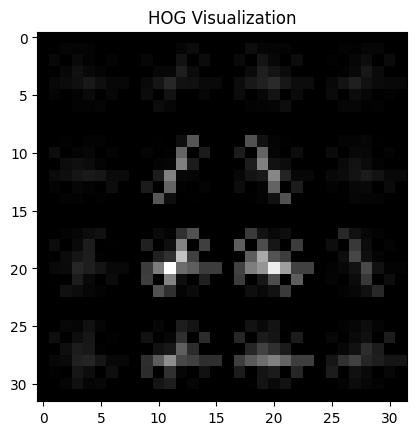

In [7]:
plt.imshow(hog_images_train[test_img], cmap='gray')
plt.title("HOG Visualization")
plt.show()

In [8]:
X_train = X_train.reshape(-1, 32*32*3)

In [9]:
# svm_plain = SVC(kernel='linear', probability=True, random_state=42)
#svm_plain.fit(X_train, y_train) ## just the Images as it is
svm_hog = SVC(kernel='linear', probability=True, random_state=42)
svm_hog.fit(hog_features_train, y_train)

#_pred_plain = svm_plain.predict(X_test)
y_pred_hog = svm_hog.predict(hog_features_test)
#accuracy_plain = accuracy_score(y_test, y_pred_plain)
accuracy_hog = accuracy_score(y_test, y_pred_hog)
print(f"Plain Images Accuracy: \nHOG Features Accuracy: {accuracy_hog}")

Plain Images Accuracy: 
HOG Features Accuracy: 0.8051800819743612


In [11]:
import joblib
joblib.dump(svm_hog, '/home/theodoros/projects/Traffic_signs/svm_hog_model.joblib')


['/home/theodoros/projects/Traffic_signs/svm_hog_model.joblib']